### Be careful when interpreting predictive models in search of causal insights.
<br>

*A joint article about causality and interpretable machine learning with Eleanor Dillon, Jacob LaRiviere, Scott Lundberg, Jonathan Roth, and Vasilis Syrgkanis from Microsoft.*
<br>
<br>


#### Original Paper by: 
###### Double/Debiased Machine Learning for Treatment and Causal Parameters
Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, James Robins (2017)

[Link to Paper](https://arxiv.org/abs/1608.00060)


#### Additional Resources:
1. [DoubleML in Python](http://aeturrell.com/2018/02/10/econometrics-in-python-partI-ML/)

---


#### Fundamental premise of double ML:

The problem is that just applying machine learning to predict outcomes $Y$ from a treatment or variable $D$ in the presence of many controls $Xs$ will lead to **biased estimates** of the model parameter $θ$. 


The double machine learning method of Chernozhukov et al. delivers point estimators that have a $\sqrt{N}$ rate of convergence for $N$ observations and are **approximately unbiased and normally distributed**.


#### Formally, using Robinson(1988)...

1. $Y$ = $D .\theta$ + $g(X)$ + $U$, where $E[U | X, D] = 0$

2. $D$ = $m(X)$ + $V$, where $E[V | X] = 0$

...with $X$ = $(x_{1}, x_{2}, \dots, x_{n})$ is a vector of controls and $D$ is treatment flag. $m$ and $g$ can be non-linear. 

The first equation, if $D$ is the exogenous condition on controls $X$, $\theta$ has the interpretation of **treatment effect** or in other words **Lift**.

The second equation, is taking care of confounding i.e. dependence of the treatment variable on controls. It is used to remove regularization bias. The confounding factors $X$ impact the treatment variable $D$ via the function $m(X)$ and the outcome via $g(X)$

##### $\theta$ is what we want to estimate

#### Typically what data scientists do is...

Estimate $D .\theta$ + $g(X)$ + $U$ using a Random Forest (for e.g.) but this only implies $\hat{\theta}$ has a slower than $\sqrt{N}$ rate of convergence due to bias in estimating $\hat{g}$



#### Steps for Double ML:

1. Estimate $\hat{V}$ = $D$ - $\hat{m}$.($X$)

2. Using remaining observations, define estimator for $\theta$, $\hat{\theta}$ which is a function of $\hat{V}$, $D$ and $X$. And estimate $\hat{g}$ as an estimate of $g$


#### How it works?

1. We randomly split the sample $N$ into 2 parts 
    1. Primary - $n$ and 
    2. Secondary - $(N-n)$ 
    where observations are indexed by $i \in I$ in A and $i \in  I^{c}$ in B.
    
    Say, we estimate $\hat{g}$ is obtained using B and given this $\hat{g}$ we get a final estimate of $\hat{\theta}$ then this, $\hat{\theta}$ is biased due to bias in learning $\hat{g}$. 
    
    The bias comes from the fact that in ML, regularization e.g. LASSO is used which induces substantive bias in $\hat{g}$.
    
    To overcome this bias, we use equation #2 $\hat{V}$ = $D$ - $\hat{m}$.($X$) to estimate conditional mean of $D$ given $X$ a.k.a. "double machine learning". By orthogonalizing $D$ from $X$ we remove direct confounding effects $\hat{\theta}$ removes regularization bias (in classical econometric literature $\hat{\theta}$ can also be interpreted as an IV estimator).
    
    
    
    
    
    
    
   

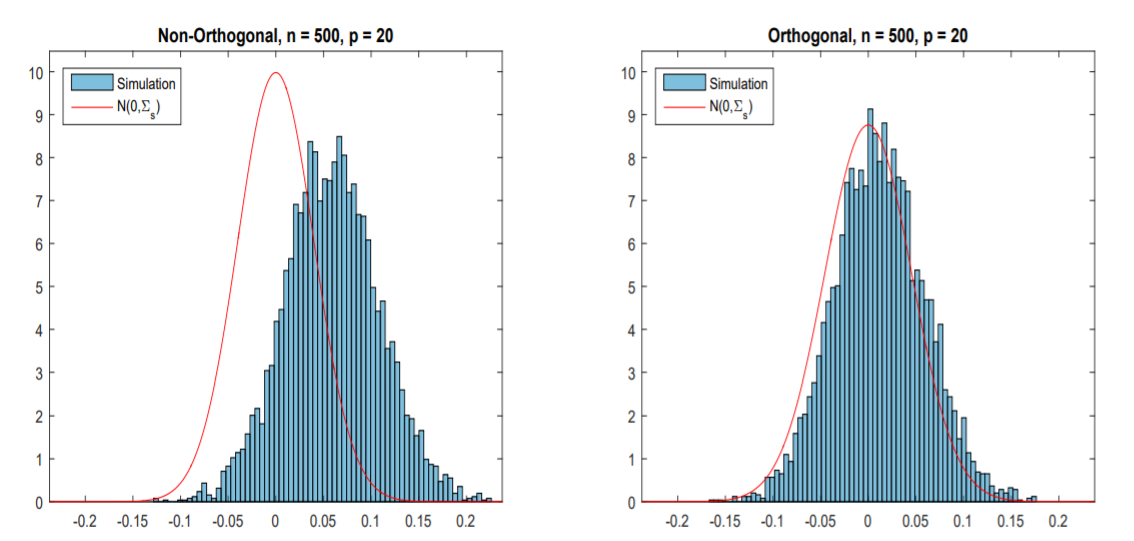

### Practical Example of Double ML

In [13]:
from utils import *
import numpy as np
import shap

## Example: Subscriber Retention
#### Predicts whether a customer will renew their product subscription

Let us assume there are the following drivers we have already found:
1. customer discount
2. ad spending
3. customer’s monthly usage
4. last upgrade
5. bugs reported by a customer
6. interactions with a customer
7. sales calls with a customer
8. macroeconomic activity.

In [2]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

#### We can begin exploring what it has learned with an interpretability tool like SHAP. We start by plotting the global importance of each feature in the model:

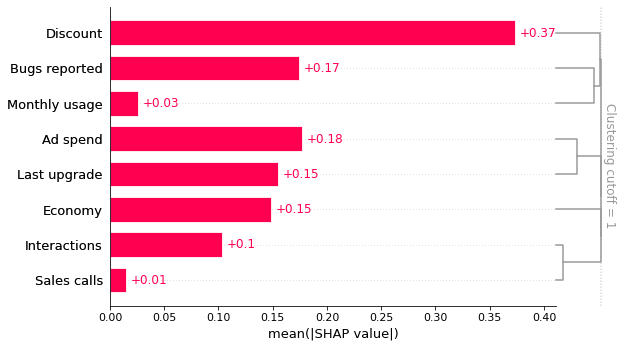

In [3]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# clust = shap.utils.hclust(X, y, linkage="complete")
clust = shap.utils.hclust(X, y, linkage="complete")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [4]:
shap_values

.values =
array([[-0.00337403,  0.03969256,  0.12269127, ...,  0.0610052 ,
         0.21601386,  0.12505414],
       [ 0.00397629,  0.06140731, -0.14353326, ..., -0.00800616,
        -0.14898813, -0.09459734],
       [-0.00277269,  0.04218393, -0.16798133, ..., -0.00372445,
         0.23478323,  0.11321171],
       ...,
       [ 0.00737297,  0.06191391, -0.16030322, ..., -0.01790942,
        -0.21498881, -0.17179264],
       [-0.02390018, -0.19699323,  0.19378395, ..., -0.04423891,
        -0.24361229, -0.1756945 ],
       [ 0.00208873,  0.05586665,  0.04176903, ...,  0.01991066,
         0.08831538,  0.04554236]], dtype=float32)

.base_values =
array([-0.83232814, -0.83232814, -0.83232814, ..., -0.83232814,
       -0.83232814, -0.83232814], dtype=float32)

.data =
array([[2.        , 2.        , 0.71905371, ..., 0.82526548, 0.80308957,
        1.        ],
       [3.        , 3.        , 0.18801708, ..., 0.28750941, 0.27539141,
        0.        ],
       [2.        , 2.        , 0.38

##### The top three factors driving the model’s prediction of customer retention:

1. Discount
2. Ad Spend
3. Bugs Reported

#### SHAP scatter plots show how changing the value of a feature impacts the model’s prediction of renewal probabilities. 

If the blue dots follow an increasing pattern, this means that the larger the feature, the higher is the model’s predicted renewal probability. 

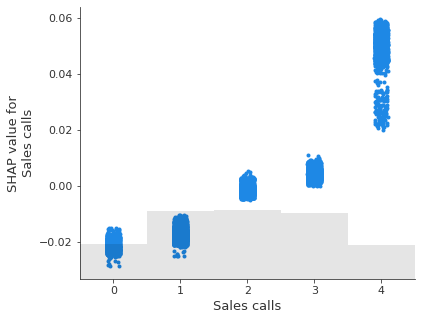

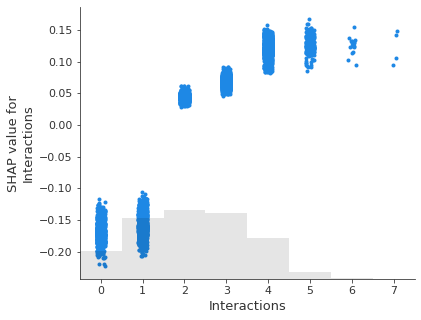

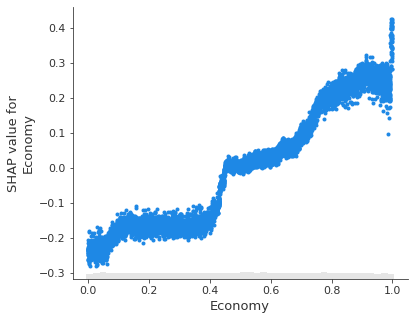

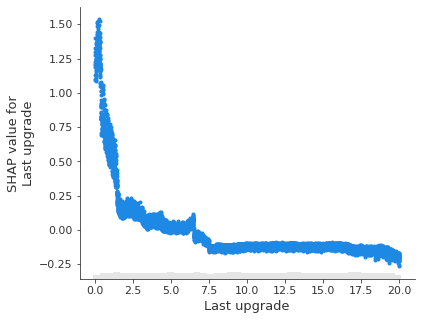

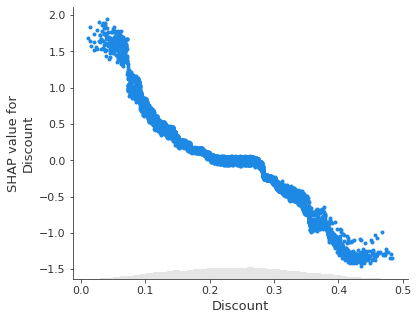

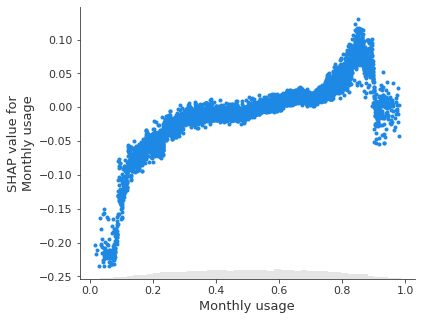

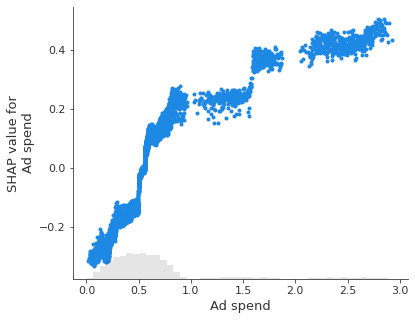

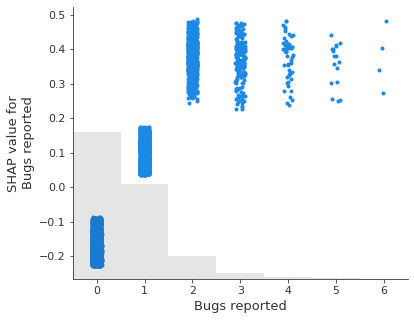

In [5]:
# make plots colored by each of the top three possible interacting features
# shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")
for i in range(len(X.columns)):
    shap.plots.scatter(shap_values[:, i]) 

#### Surprising findings from above:

1. More bugs --> More likely to renew!
2. More discounts --> less likely to renew!


...Why?

#### And here in lies the principle of causality. 

The business goal is not always prediction, instead it is to **make predictions**
Goal --> What actions our company can take to retain more customers. We should care about how each *X* feature relates to *Y*, not just in our training distribution, but the counterfactual scenario produced when the world changes.

### Causal implies...
Changing an aspect of the world with everything else remaining the same, how it affects the outcome.


#### Causal relationships can (should) be modelled using DAGs. 
Let's take an example of the same...

1. Solid ovals represent features that we observe
2. Dashed ovals represent hidden features that we don’t measure. 

Each feature is a function of all the features with an arrow to it, plus some random effects.

In [ ]:
# !conda install -c anaconda graphviz
%run dags.py

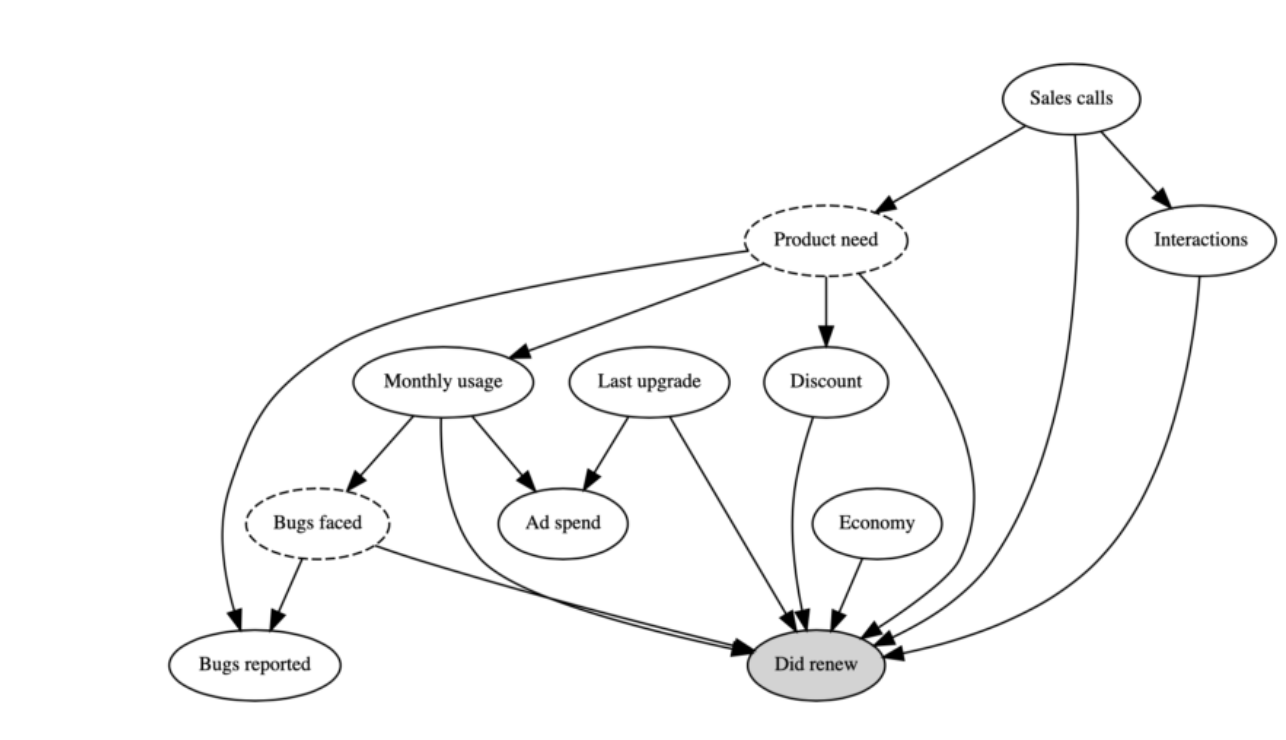

#### Unmeasured Confounding Features:

Counfounding --> they impact the treatment and outcome

Unmeasured --> hidden, not obvious or measurable

In this case **Product Need** is an obvious confounding variable and also unmeasurable.

Higher product need --> use more --> encounter bugs more --> report bugs more


#### Because we cannot directly measure Product Need, the correlation between "bugs reported" and "renewal probability" captures the:

1. Small -ve effect of bugs faced and
2. Large +ve effect of Product Need.

An example can be see from the SHAP values vs. true causal effect (let's assume that this is known to the modeller before hand)

In [ ]:
%run shap_vs_true_causal.py

shap.plots.scatter(shap_values, overlay={
    "True causal effects": marginal_effects(generator, 10000, X.columns)
})

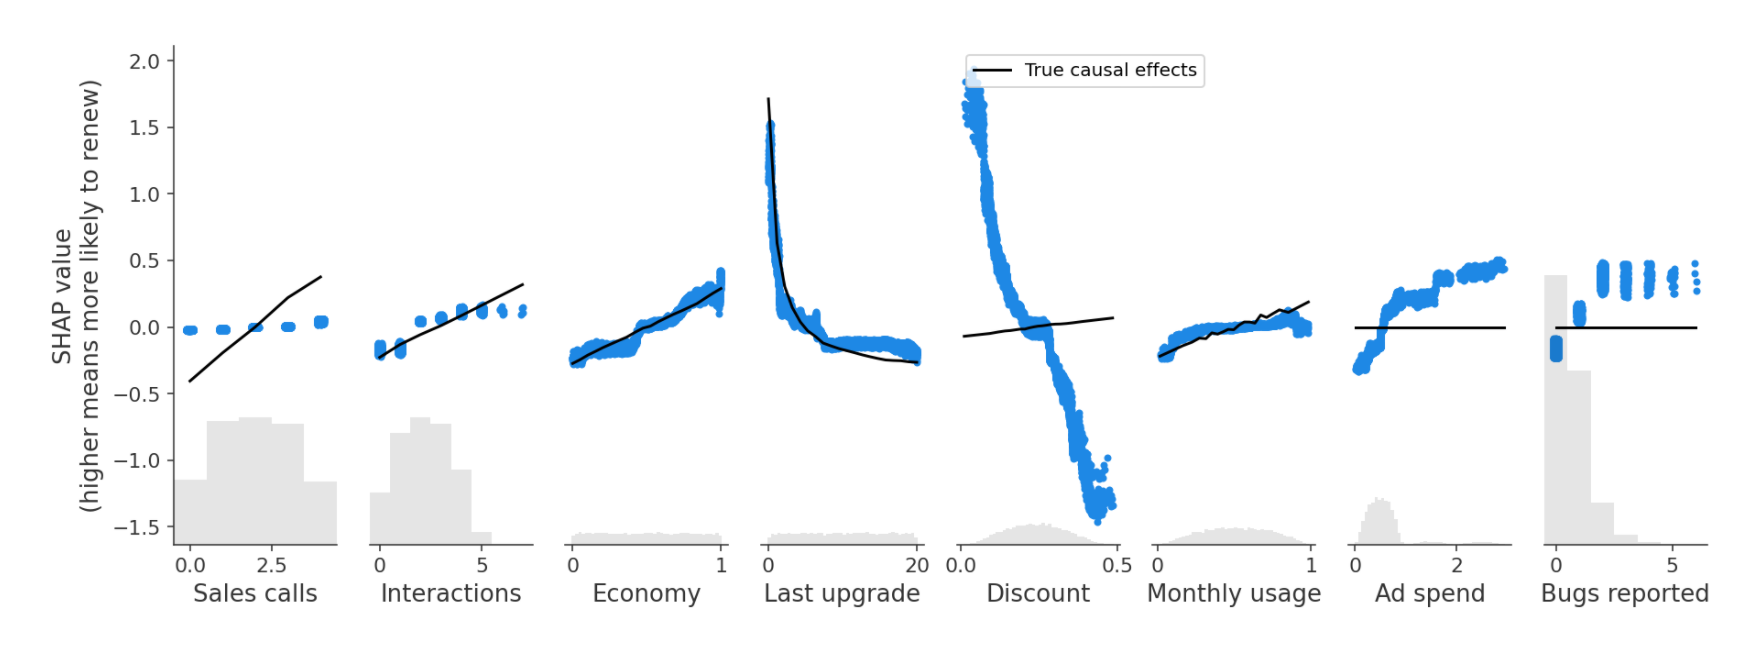

#### Causal relationship shows...

1. Bugs reported and likely to churn is almost zero
2. Discounts and likely to churn slightly positive

Put in another way, 2 customers exactly the same product need, the one with larger discount is more likely to renew


#### Curious case of Ad Spend

Ad Spend is driven by Last Upgrade and Monthly Usage, so in this case --> Observed Confounders

So, Ad Spend correlated with other features in the model, because of which predictive model picks it up. 

But in reality, there is *no causal effect* of Ad Spend on likelihood of renewal!

#### So, when predictive models can accurately measure causal effects, and when they cannot?

Let's take an example, of a true causal effect that is picked by the predictive model.

In our case: Predictive model does a good job of capturing causal effect of the Economy. **Why?**


---


It is because of **strong independent component** --> no measured or unmeasured confounders affecting it!


>   "But to trust that the Economy effect is causal we also need to check for unobserved confounding. Checking for unmeasured confounders is harder and requires using domain knowledge"


For classic predictive ML models to deliver causal results the features need to be **independent not only of other features in the model, but also of unobserved confounders.** 


> "In most real-world datasets features are not independent and unconfounded, so standard predictive models will not learn the true causal effects. As a result, explaining them with SHAP will not reveal causal effects."

### Observed Confounding


> A feature is “confounded” when there is **another feature that causally affects both the original feature and the outcome we are predicting.**

A good example from our world is we tend to give promotions to POCs which are more likely to use them and hence generate more sales. This could be *because* these POCs have higher in-store promotions running. Hence in-store promotions are the confounding variable. 

##### The good news is that we can measure all the features that could confound it.

For example, with Ad Spend we will be able to tell what features could confound Ad Spend and then adjust for those features, to get an *unconfounded estimate* of the causal effect of Ad Spend on product renewal.


One such method is **Double/Debiased Machine Learning**

> "It uses any machine learning model you want to first deconfound the feature of interest (i.e. Ad Spend) and then estimate the average causal effect of changing that feature (i.e. the average slope of the causal effect)."


Steps involved in Double ML:

1. Train a model to predict a feature of interest (e.g. Ad Spend) using set of confounders 
<br>
$$\hat{x_{1}} =  f(x_{2}, x_{3}, \dots, x_{n})$$
<br>

2. Train a model to predict outcome (i.e. likelihood to renew) using same set of confounders 
<br>
$$\hat{y}  =  f(x_{2}, x_{3}, \dots, x_{n})$$
<br>

3. Train a model to predict residual variation of the outcome (i.e. variation after subtracting our prediction) using the residual variation of the causal feature of interest

<br>
$$y - \hat{y}  =  f(x_{1} - \hat{x_{1}})$$
<br>


If we believe (data scientist's hypothesis) that $x_{1}$ **does impact** $y$, then ...
<br>
<br>
...here $(x_{1} - \hat{x_{1}})$ i.e. captures the part of $x_{1}$ that cannot be predicted by other confounding features **should be correlated**...
<br>
<br>
...**with** $(y - \hat{y})$ i.e. the part of $y$ that cannot be predicted by other confounding features.

#### Libraries to do Double ML (instead of manual):

1. econML
2. CausalML
3. ... *(many more)*
<br>
<br>

##### Here we use econML’s LinearDML model.




In [ ]:
%run econml.py

#### Output returns a p-value whether or not the treatment has a non-zero causal effect

This works beautifully in our scenario, correctly identifying that there is no evidence for a causal effect of ad spending on renewal (P-value = 0.85):

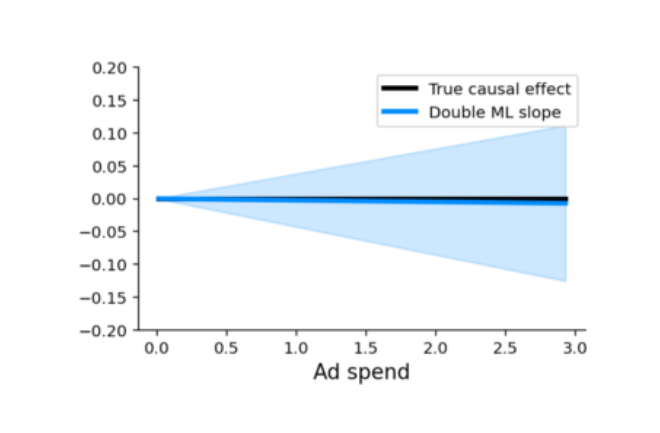

Double ML only works when you can measure and identify all the possible confounding features for which you want to estimate causal effects.



### Non confounding redundancy

> *This occurs when the feature we want causal effects for causally drives, or is driven by, another feature included in the model, but that other feature is not a confounder of our feature of interest.*


Sales Calls directly impact retention, but also have an indirect effect on retention through Interactions. 

When we include both the Interactions and Sales Calls features in the model the causal effect shared by both features is **forced to spread out between them.**


We can see this in the SHAP scatter plots above, which show how XGBoost underestimates the true causal effect of Sales Calls because most of that effect got put onto the Interactions feature.


> *For example, if we removed Interactions from the model then we will capture the full effect of making a sales call on renewal probability.*


#### The authors make a good suggestion at the end...

1. We never really know the true causal graph. So it can be hard to know when a feature is redundant with our feature of interest

2. If it is because of confounding then we should control for that feature using doubleML

3. Whereas if it is a downstream consequence drop the feature if we want full causal effect.


> *Controlling for a feature we shouldn’t tends to hide or split up causal effects, while failing to control for a feature we should have controlled for tends to infer causal effects that do not exist.*


### Unobserved confounding

The Discount and Bugs Reported features both suffer from unobserved confounding because not all important variables (e.g., Product Need and Bugs Faced) are measured in the data. 
<br>
<br>

In this case, **double ML, will fail**. This is why double ML estimates a large negative causal effect for the Discount feature even when controlling for all other observed features:

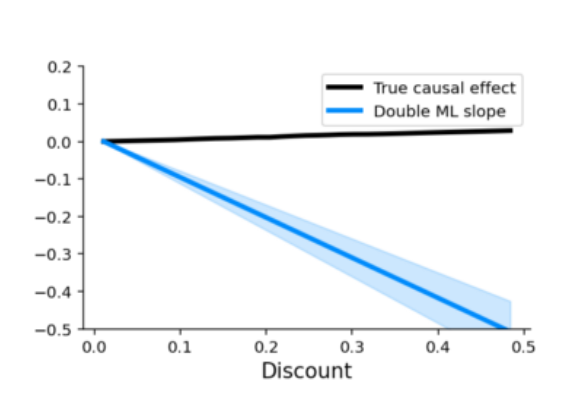

> *In these situations, the only way to identify causal effects that can inform policy is to create or exploit some **randomization that breaks the correlation** between the features of interest and the unmeasured confounders. **Randomized experiments remain the gold standard for finding causal effects** in this context.*

Specialized causal tools based on the principals of **instrumental variables, differences-in-differences, or regression discontinuities** can sometimes exploit partial randomization even in cases where a full experiment is impossible.